<a href="https://colab.research.google.com/github/sandhya111205/yolo_custom/blob/main/cnn_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from keras import regularizers
from keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/project/drowsiness_detection/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [3]:
# Loading Dataset:

nb_classes         = 2
img_rows, img_cols = 86 , 86
batch_size         = 32

In [4]:
# Loading Dataset:
train_data_dir   = '/content/dataset/data/train/'
test_data_dir    = '/content/dataset/data/test/'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True
)

train_set = train_datagen.flow_from_directory(
  train_data_dir,
  color_mode  = 'grayscale',
  target_size = (img_rows, img_cols),
  batch_size  = batch_size,
  class_mode  = 'categorical',
  shuffle     = True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(
	test_data_dir,
  color_mode  = 'grayscale',
  target_size = (img_rows, img_cols),
  batch_size  = batch_size,
  class_mode  = 'categorical',
  shuffle     = True
)

Found 81675 images belonging to 2 classes.
Found 3223 images belonging to 2 classes.


       open eyes  close eyes
train      41295       40380
      open eyes  close eyes
test       1657        1566


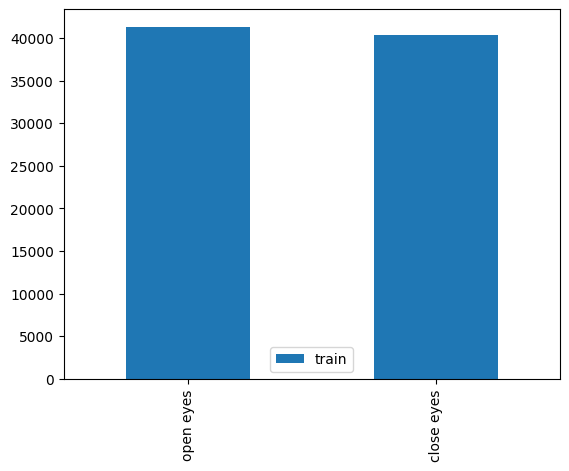

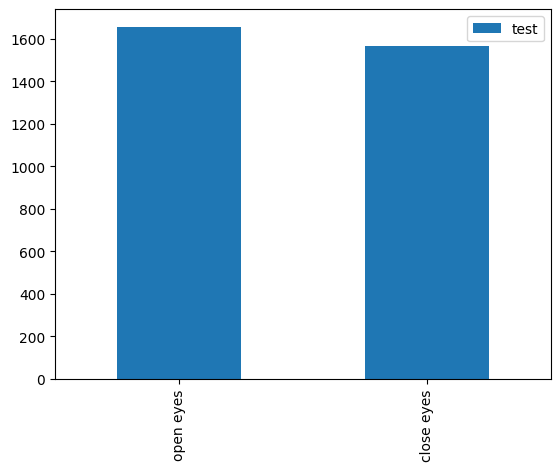

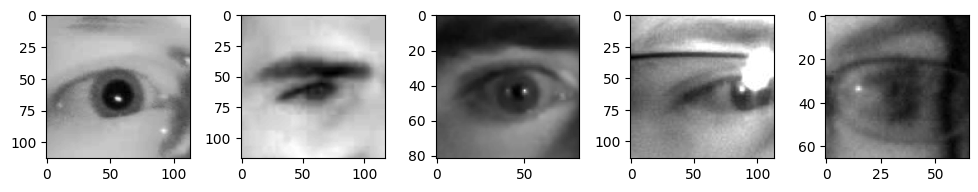

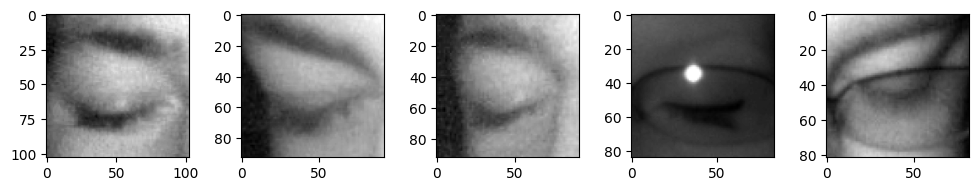

In [5]:

# Exploratory Data Analysis:

train_set.class_indices

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_data_dir, 'train')
test_count  = count_exp(test_data_dir, 'test')

print(train_count)
print(test_count)

"""*Taking a glance at the distribution of both the training data and testing data.*"""

# Plotting training data dist
train_count.transpose().plot(kind = 'bar')

# Plotting testing data dist
test_count.transpose().plot(kind = 'bar')

# show a few samples of the dataset:
def plot_imgs(item_dir, top = 10):
    all_item_dirs = os.listdir(item_dir)
    item_files    = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize = (10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx + 1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap = 'gray')

plot_imgs(train_data_dir + 'open eyes')
plot_imgs(train_data_dir + 'close eyes')





In [6]:
# Model (CNN):
## Building the model:
###The following function shows the structure of our neural network, which is a convolutional neural net, and we'll be using Adam's optimizer and softmax, relu as activation functions:

def build_model(nb_classes, input_shape):

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(86, 86,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #Faltten the model
  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(nb_classes, activation='softmax'))

  model.compile(
    optimizer = "adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [7]:
# Creating an instance of the model and printing the summary:
model = build_model(nb_classes, (img_rows, img_cols, 1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 86, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 86, 86, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 86, 86, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 43, 43, 64)        0

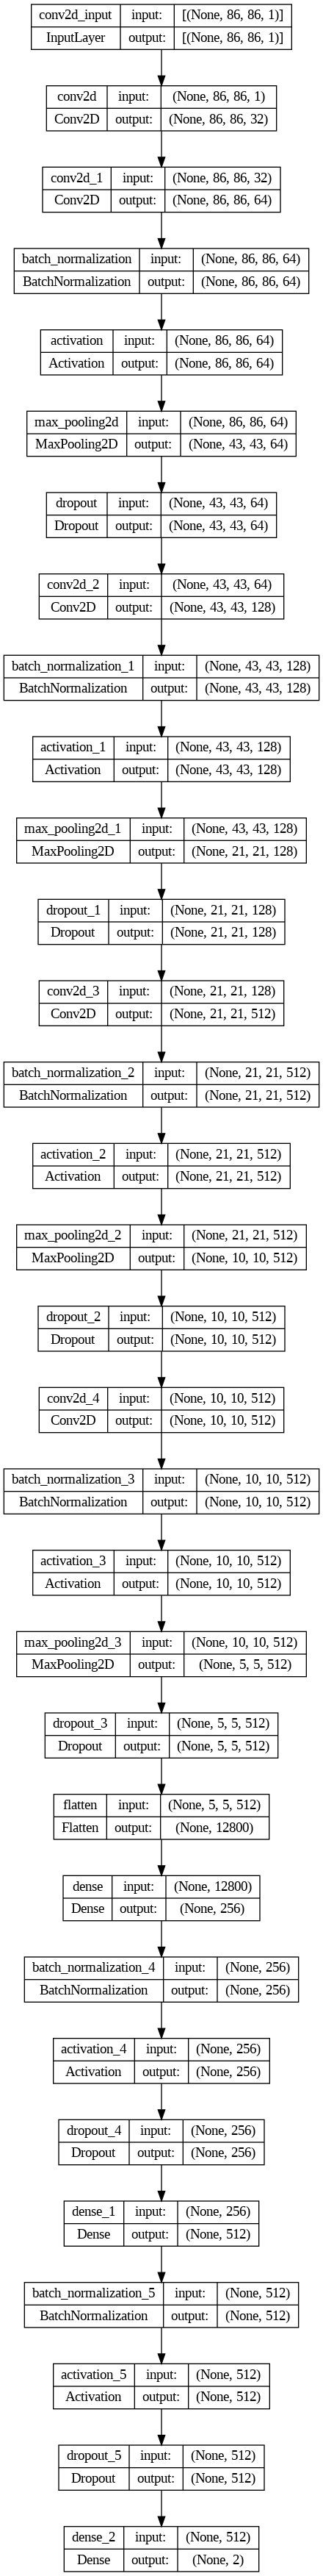

In [8]:
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)


In [9]:

# Training the model:
## Now we will define the path for the weights, the logs and set up callback functions for checkpoints. early stopping for avoiding overfitting training data and ReduceLROnPlateau for learning rate.

chk_path = 'drowsiness.h5' #win thb tsajel l weights mte3k
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(
    filepath       = chk_path,
    save_best_only = True,
    verbose        = 1,
    mode           = 'min',
    moniter        = 'val_loss'
)

earlystop = EarlyStopping(
    monitor              = 'val_loss',
    min_delta            = 0,
    patience             = 3,
    verbose              = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor   = 'val_loss',
    factor    = 0.2,
    patience  = 6,
    verbose   = 1,
    min_delta = 0.0001
)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]






In [10]:
## The funciton down below is the one responsible for training the model, and the steps of training are shown in the second next cell.
def train_model(train, test, epochs, callbacks):
  steps_per_epoch  = train.n // train.batch_size
  validation_steps = test.n // test.batch_size

  hist = model.fit(
      x                = train,
      validation_data  = test,
      epochs           = epochs,
      callbacks        = callbacks,
      steps_per_epoch  = steps_per_epoch,
      validation_steps = validation_steps
  )

  return hist

hist = train_model(train_set, test_set, 24, callbacks)


Epoch 1/24
2552/2552 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.9318
Epoch 1: val_loss improved from inf to 1.76367, saving model to drowsiness.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2552/2552 [==============================] - 183s 67ms/step - loss: 0.6942 - accuracy: 0.9318 - val_loss: 1.7637 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 2/24
2552/2552 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.9600
Epoch 2: val_loss improved from 1.76367 to 1.45271, saving model to drowsiness.h5
2552/2552 [==============================] - 169s 66ms/step - loss: 0.3729 - accuracy: 0.9600 - val_loss: 1.4527 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 3/24
2552/2552 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9660
Epoch 3: val_loss improved from 1.45271 to 0.83540, saving model to drowsiness.h5
2552/2552 [==============================] - 169s 66ms/step - loss: 0.3126 - accuracy: 0.9660 - val_loss: 0.8354 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 4/24
2552/2552 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.9693
Epoch 4: val_loss improved from 0.83540 to 0.37115, saving model to drowsiness.h5
2552/2552 [==

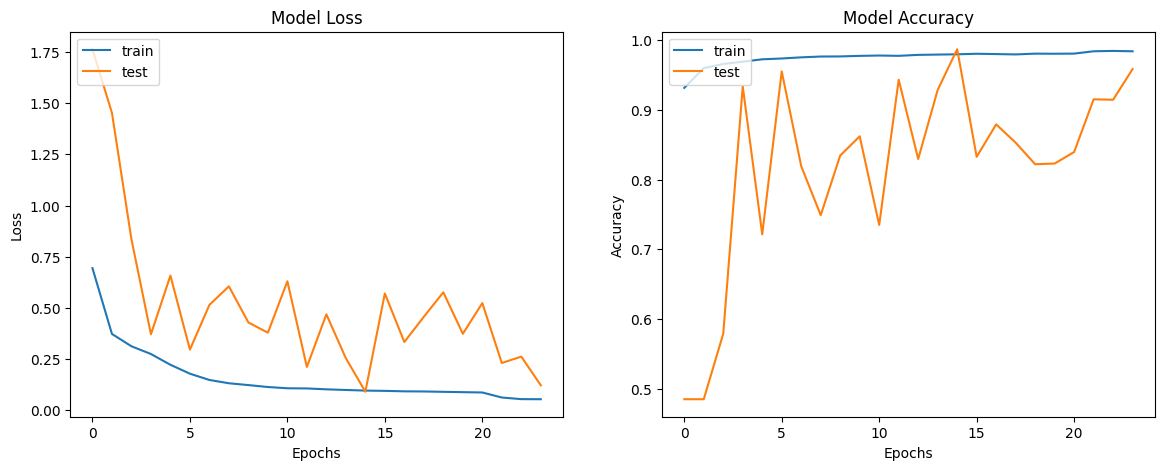

In [11]:
# Plotting the loss & accuracy:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()





In [12]:
# Evaluating the model
train_loss, train_acc = model.evaluate(train_set)
test_loss, test_acc   = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

101/101 [==============================] - 3s 28ms/step - loss: 0.1217 - accuracy: 0.9584
final train accuracy = 98.81 , validation accuracy = 95.84


In [13]:
# Save the weights
model.save_weights('/content/drowsiness.h5')
model.save('drowsiness.keras')

In [14]:
#Plot confusion matrix:
y_pred = model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_set.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

2553/2553 [==============================] - 112s 44ms/step
Confusion Matrix
[[19825 20555]
 [20277 21018]]


In [15]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

  close eyes       0.49      0.49      0.49     40380
   open eyes       0.51      0.51      0.51     41295

    accuracy                           0.50     81675
   macro avg       0.50      0.50      0.50     81675
weighted avg       0.50      0.50      0.50     81675



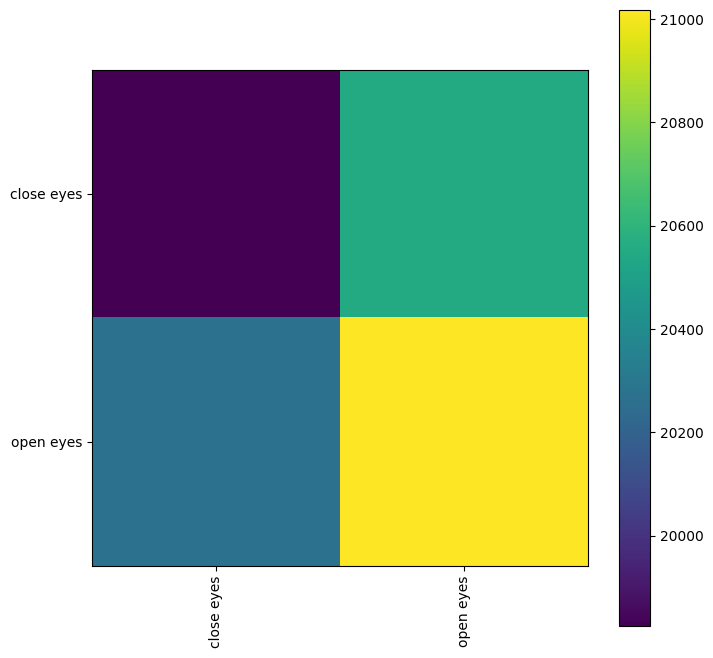

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model


#Import Haarcascade classifiers:
face = cv2.CascadeClassifier('/content/drive/MyDrive/project/project1/harcascade/haarcascade_frontalface_default.xml')
leye = cv2.CascadeClassifier('/content/drive/MyDrive/project/project1/harcascade/haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('/content/drive/MyDrive/project/project1/harcascade/haarcascade_righteye_2splits.xml')
lbl=['close eyes','open eyes']

#Load the trained model:
model = load_model('/content/drowsiness.keras')
#path = os.getcwd()

In [ ]:

#Testing on image:
frame= cv2.imread("/content/drive/MyDrive/project/project1/train/close1.jpg")
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
count=0
score=0
#thicc=2
height,width = frame.shape[:2]
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
left_eye = leye.detectMultiScale(gray)
right_eye = reye.detectMultiScale(gray)
cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )
for (x,y,w,h) in faces:
  cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )
for (x,y,w,h) in right_eye:
    r_eye=frame[y:y+h,x:x+w]
    count=count+1
    r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
    r_eye = cv2.resize(r_eye,(86,86))
    r_eye= r_eye/255
    r_eye= r_eye.reshape(86,86,-1)
    r_eye = np.expand_dims(r_eye,axis=0)
    rpred = model.predict(r_eye)
    rpred = np.argmax(rpred, axis=1)


    if(rpred[0]==1):
        lbl='Open'
    if(rpred[0]==0):
        lbl='Closed'
    break
for (x,y,w,h) in left_eye:
    l_eye=frame[y:y+h,x:x+w]
    count=count+1
    l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)
    l_eye = cv2.resize(l_eye,(86,86))
    l_eye= l_eye/255
    l_eye=l_eye.reshape(86,86,-1)
    l_eye = np.expand_dims(l_eye,axis=0)
    lpred=model.predict(l_eye)
    lpred=np.argmax(lpred,axis=1)
    if(lpred[0]==1):
        lbl='Open'
    if(lpred[0]==0):
        lbl='Closed'
    break
if(rpred[0]==0 and lpred[0]==0):
    cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
# if(rpred[0]==1 or lpred[0]==1):
else:
    cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)

cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
cv2_imshow(frame)

In [ ]:
import cv2
import numpy as np

# Load pre-trained models and cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
model = # Load your pre-trained eye state classification model here

# Load the image
image_path = "/content/drive/MyDrive/project/project1/train/close1.jpg"
frame = cv2.imread(image_path)

# Convert image to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(25, 25))

for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]

    # Detect eyes within the face region
    eyes = eye_cascade.detectMultiScale(roi_gray)

    for (ex, ey, ew, eh) in eyes:
        eye_roi = roi_color[ey: ey + eh, ex: ex + ew]

        # Preprocess the eye region for classification
        eye_roi = cv2.resize(eye_roi, (86, 86))
        eye_roi = eye_roi / 255.0  # Normalize
        eye_roi = np.expand_dims(eye_roi, axis=0)

        # Predict eye state (open/closed)
        prediction = model.predict(eye_roi)
        state = "Open" if prediction[0][1] > 0.5 else "Closed"

        # Display the predicted state
        cv2.putText(frame, state, (x + ex, y + ey - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the processed image
cv2.imshow('Eye Detection', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Load pre-trained models and cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
model = # Load your pre-trained eye state classification model here

# Main processing loop
cap = cv2.VideoCapture(0)  # Use 0 for default camera

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(25, 25))

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        # Detect eyes within the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)

        for (ex, ey, ew, eh) in eyes:
            eye_roi = roi_color[ey: ey + eh, ex: ex + ew]

            # Preprocess the eye region for classification
            eye_roi = cv2.resize(eye_roi, (86, 86))
            eye_roi = eye_roi / 255.0  # Normalize
            eye_roi = np.expand_dims(eye_roi, axis=0)

            # Predict eye state (open/closed)
            prediction = model.predict(eye_roi)
            state = "Open" if prediction[0][1] > 0.5 else "Closed"

            # Display the predicted state
            cv2.putText(frame, state, (x + ex, y + ey - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the processed frame
    cv2.imshow('Eye Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()
